In [15]:
from matplotlib import pyplot as plt
import numpy as np

### theory data

In [67]:
THEORY_DELAYS = [10, 30, 50, 70, 90, 110]

def load_theory_result(power: int, delays=THEORY_DELAYS):

    dirmap = {
        10: "fig4a",
        50: "fig4a",
        100: "fig4a",
    }

    q_values = None
    intensities = []

    for delay in delays:
        file_path = f"{dirmap[power]}/rdp47_{power:03d}_{delay:03d}fs.txt"
        data = np.loadtxt(file_path)

        if q_values is not None:
            assert np.all(q_values == data[:,0] / 1e10)
        else:
            q_values = data[:,0] / 1e10

        intensities.append(data[:,1])

    data_stack = np.stack([q_values] + intensities)
    assert data_stack.shape[0] == len(delays) + 1

    return data_stack.T

In [68]:
theoretical_data = load_theory_result(10)
print(theoretical_data.shape)

(50, 7)


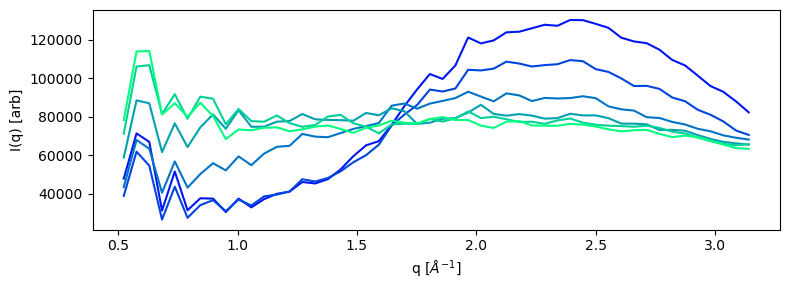

In [69]:
# RP vs Delay Time

# --- peak positions to monitor later (in array idx)
new_peak_pos = 90
wat_peak_pos = 280

# --- plotting
plt.figure(figsize=(8,3))

plt.subplot(111)
plt.title("")

for i,b in enumerate(THEORY_DELAYS):
    plt.plot(theoretical_data[:,0], theoretical_data[:,i+1], color=plt.cm.winter(b/np.array(THEORY_DELAYS).max()))

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
# plt.xlim([0.3, 2.5])
# plt.ylim([0.0, 0.007])

plt.tight_layout()
plt.show()

### experimental data

In [25]:
experimental_data = np.loadtxt("../csvs/water_Iq_v_time.csv", delimiter=',')
print(experimental_data.shape)
time_delays = np.array([10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0,110.0])

(500, 12)


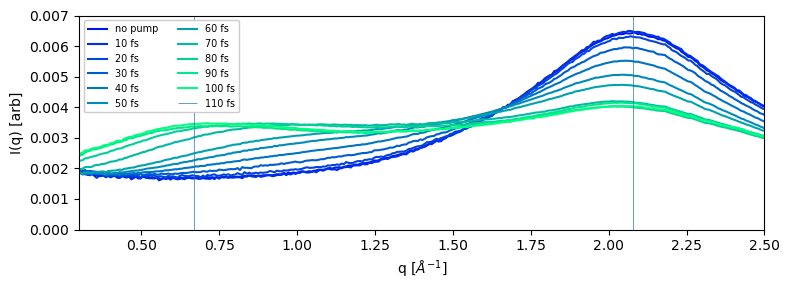

In [53]:
# RP vs Delay Time

# --- peak positions to monitor later (in array idx)
new_peak_pos = 90
wat_peak_pos = 280

# --- plotting
plt.figure(figsize=(8,3))

plt.subplot(111)
plt.title("")

for i,b in enumerate(time_delays):
    
    plt.plot(experimental_data[:,0], experimental_data[:,i+1], color=plt.cm.winter(b/time_delays.max()))

plt.xlabel('q [$\AA^{-1}]$')
plt.ylabel('I(q) [arb]')
plt.xlim([0.3, 2.5])
plt.ylim([0.0, 0.007])

plt.vlines(
    [
        experimental_data[:,0][new_peak_pos],
        experimental_data[:,0][wat_peak_pos]
    ], 
    0.0, 0.007, lw=0.5
)

plt.legend(['no pump'] + ['%d fs' % b for b in time_delays], 
           prop={'size': 7}, ncol=2, framealpha=1.0)

plt.tight_layout()
plt.show()